In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from itertools import combinations


compute_dataset = pd.read_csv("../data/logfile-v10.csv", delimiter=";")
compute_dataset.head()

storage_dataset = pd.read_csv("../data/logfile-storage-v5.csv", delimiter=";")
storage_dataset.head()

network_dataset = pd.read_csv("../data/logfile-network-v7.csv", delimiter=";")
labels = np.unique(compute_dataset['datacenter_name'])
network_dataset.head()

,datacenter_id,datacenter_name,id,type,role,level,bandwidth,total_used_bandwidth,traffic_history,ports,duration,active_duration,power_per_port,low_power,high_power,is_active,Unnamed: 16
0,0,Datacenter_1,0,switch,access switch,0,360000,2427.0,162.0:93.0:71.0:72.0:79.0:73.0:71.0:71.0:73.0:...,"400,True,0.24269999999999994,0,12,10000,2427.0...",3.6094,0.006742,8,132,132,True,NaN
1,0,Datacenter_1,1,switch,access switch,0,360000,3573.0,89.0:89.0:95.0:198.0:218.0:156.0:90.0:109.0:17...,"402,True,0.35729999999999995,1,12,10000,3573.0...",3.6094,0.009925,8,132,132,True,NaN
2,0,Datacenter_1,2,switch,access switch,0,360000,2492.0,94.0:68.0:73.0:61.0:73.0:83.0:74.0:63.0:73.0:7...,"404,True,0.24919999999999998,2,12,10000,2492.0...",3.6094,0.006922,8,132,132,True,NaN
3,0,Datacenter_1,3,switch,access switch,0,360000,2335.0,64.0:64.0:64.0:73.0:74.0:64.0:74.0:74.0:56.0:6...,"406,True,0.23349999999999999,3,12,10000,2335.0...",3.6094,0.006486,8,132,132,True,NaN
4,0,Datacenter_1,4,switch,access switch,0,360000,2436.0,70.0:64.0:57.0:75.0:72.0:65.0:75.0:66.0:63.0:7...,"408,True,0.24359999999999996,4,12,10000,2436.0...",3.6094,0.006767,8,132,132,True,NaN


### Current Network Traffic

Switch ID'0' at datacenter 'Datacenter_1' has used 2427.0 due to 34 sources of traffic.
Switch ID'1' at datacenter 'Datacenter_1' has used 3573.0 due to 34 sources of traffic.
Switch ID'2' at datacenter 'Datacenter_1' has used 2492.0 due to 34 sources of traffic.
Switch ID'3' at datacenter 'Datacenter_1' has used 2335.0 due to 34 sources of traffic.
Switch ID'4' at datacenter 'Datacenter_1' has used 2436.0 due to 34 sources of traffic.
Switch ID'5' at datacenter 'Datacenter_1' has used 2543.0 due to 34 sources of traffic.
Switch ID'6' at datacenter 'Datacenter_1' has used 2317.0 due to 34 sources of traffic.
Switch ID'7' at datacenter 'Datacenter_1' has used 2287.0 due to 34 sources of traffic.
Switch ID'8' at datacenter 'Datacenter_1' has used 2298.0 due to 34 sources of traffic.
Switch ID'9' at datacenter 'Datacenter_1' has used 2377.0 due to 34 sources of traffic.
Switch ID'10' at datacenter 'Datacenter_1' has used 5178.0 due to 34 sources of traffic.
Switch ID'11' at datacenter 'Da

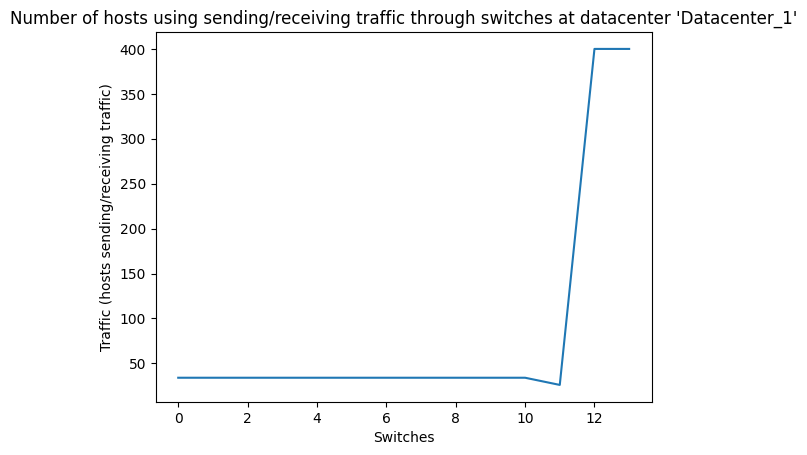

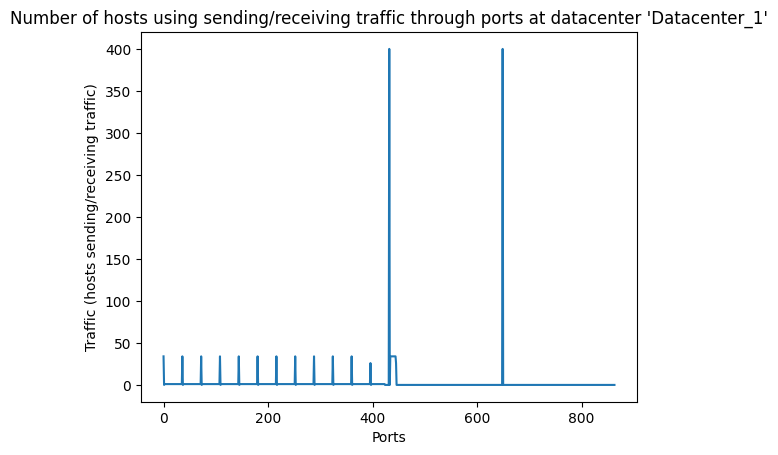

Switch ID'0' at datacenter 'Datacenter_2' has used 1990.0 due to 34 sources of traffic.
Switch ID'1' at datacenter 'Datacenter_2' has used 2306.0 due to 34 sources of traffic.
Switch ID'2' at datacenter 'Datacenter_2' has used 4041.0 due to 34 sources of traffic.
Switch ID'3' at datacenter 'Datacenter_2' has used 5209.0 due to 34 sources of traffic.
Switch ID'4' at datacenter 'Datacenter_2' has used 6124.0 due to 34 sources of traffic.
Switch ID'5' at datacenter 'Datacenter_2' has used 7792.0 due to 15 sources of traffic.
Switch ID'6' at datacenter 'Datacenter_2' has used 27462.0 due to 185 sources of traffic.
Switch ID'8' at datacenter 'Datacenter_2' has used 27462.0 due to 185 sources of traffic.


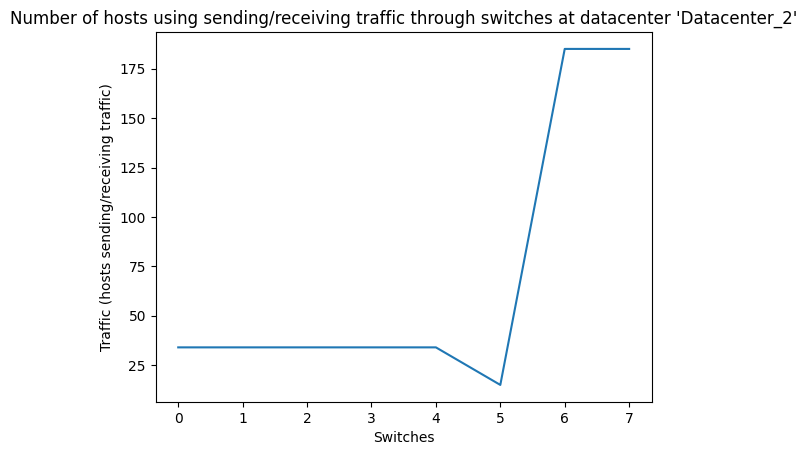

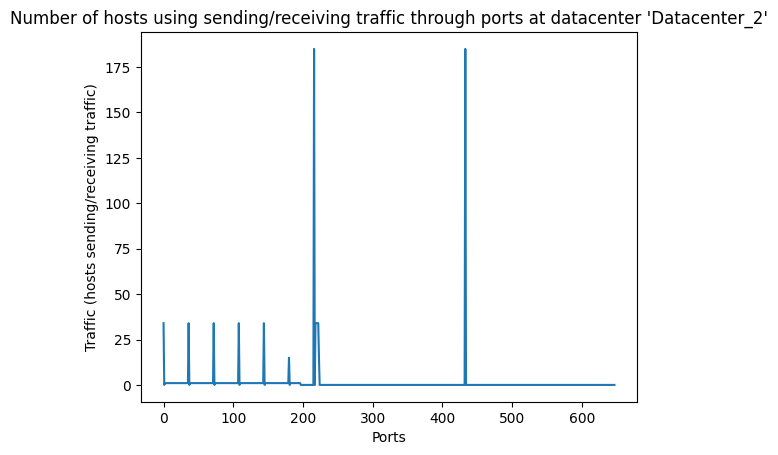

Switch ID'0' at datacenter 'Datacenter_3' has used 5313.0 due to 34 sources of traffic.
Switch ID'1' at datacenter 'Datacenter_3' has used 2078.0 due to 34 sources of traffic.
Switch ID'2' at datacenter 'Datacenter_3' has used 2332.0 due to 34 sources of traffic.
Switch ID'3' at datacenter 'Datacenter_3' has used 2094.0 due to 34 sources of traffic.
Switch ID'4' at datacenter 'Datacenter_3' has used 3900.0 due to 34 sources of traffic.
Switch ID'5' at datacenter 'Datacenter_3' has used 4817.0 due to 20 sources of traffic.
Switch ID'6' at datacenter 'Datacenter_3' has used 20534.0 due to 190 sources of traffic.
Switch ID'8' at datacenter 'Datacenter_3' has used 20534.0 due to 190 sources of traffic.


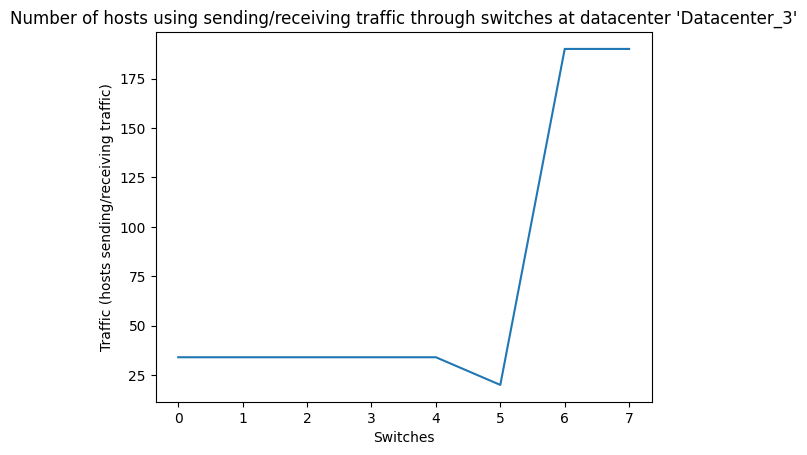

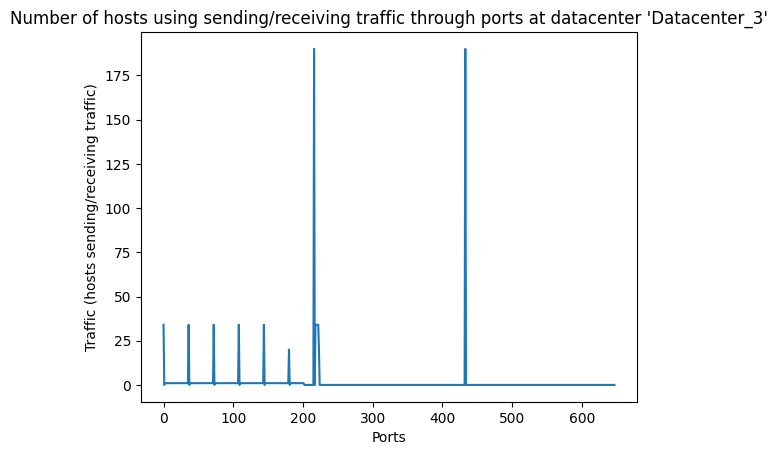

Switch ID'0' at datacenter 'Datacenter_4' has used 2015.0 due to 34 sources of traffic.
Switch ID'1' at datacenter 'Datacenter_4' has used 2010.0 due to 34 sources of traffic.
Switch ID'2' at datacenter 'Datacenter_4' has used 4705.0 due to 34 sources of traffic.
Switch ID'3' at datacenter 'Datacenter_4' has used 16298.0 due to 34 sources of traffic.
Switch ID'4' at datacenter 'Datacenter_4' has used 4744.0 due to 34 sources of traffic.
Switch ID'5' at datacenter 'Datacenter_4' has used 0.0 due to 34 sources of traffic.
Switch ID'6' at datacenter 'Datacenter_4' has used 0.0 due to 34 sources of traffic.
Switch ID'7' at datacenter 'Datacenter_4' has used 0.0 due to 34 sources of traffic.
Switch ID'8' at datacenter 'Datacenter_4' has used 0.0 due to 3 sources of traffic.
Switch ID'9' at datacenter 'Datacenter_4' has used 29772.0 due to 275 sources of traffic.
Switch ID'11' at datacenter 'Datacenter_4' has used 29772.0 due to 275 sources of traffic.


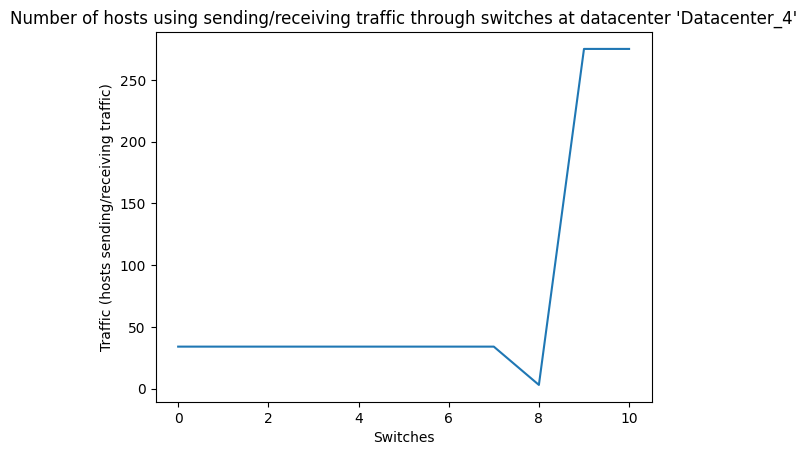

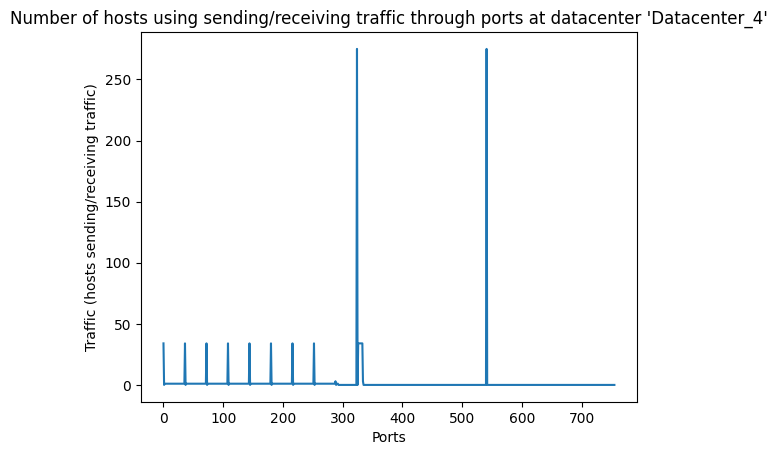

1200.0 network traffic sources at datacenter 'Datacenter_1'.
555.0 network traffic sources at datacenter 'Datacenter_2'.
570.0 network traffic sources at datacenter 'Datacenter_3'.
825.0 network traffic sources at datacenter 'Datacenter_4'.
The cloud provider has 3150.0 sources of network traffic.
Cloud provider has 0 powered down switches, and 1702 powered down ports.


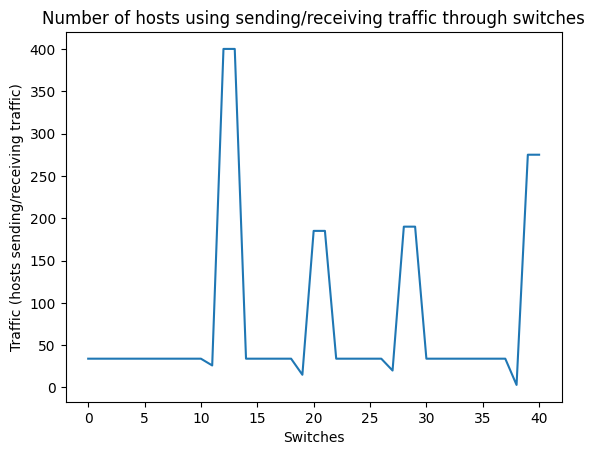

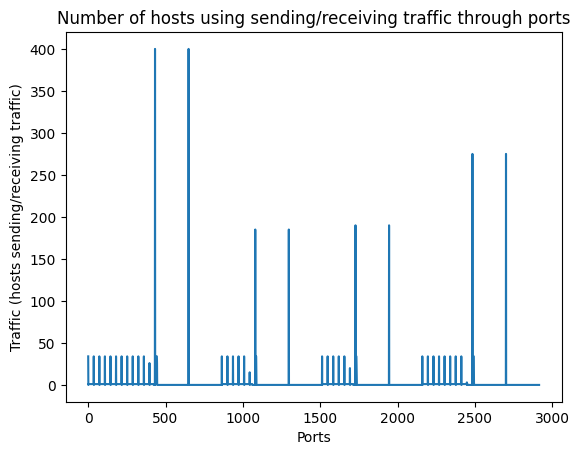

In [2]:
used_bandwidth_per_datacenter = np.array([])
used_bandwidth_per_switch = np.array([])
used_bandwidth_per_port = np.array([])

traffic_per_datacenter = np.array([])
traffic_per_switch = np.array([])
traffic_per_port = np.array([])

num_powered_down_switches = 0
num_powered_down_ports = 0

datacenter_max_power = np.array([])
datacenter_max_bw = np.array([])
datacenter_switch_devices = np.array([])
datacenter_switchports = np.array([])

datacenter_current_power = np.array([])
datacenter_current_used_bw = np.array([])
datacenter_current_used_or_unavailable_bw = np.array([])
datacenter_switches_on = np.array([])
datacenter_switches_off = np.array([])
datacenter_switchports_on = np.array([])
datacenter_switchports_off = np.array([])

for datacenter_name in labels:
    used_bandwidth_per_datacenter_per_switch = np.array([])
    traffic_per_datacenter_per_switch = np.array([])
    
    used_bandwidth_per_datacenter_per_port = np.array([])
    traffic_per_datacenter_per_port = np.array([])
    
    
    max_power = 0
    max_bw = 0
    sws = 0
    switchports = 0
    
    current_power = 0
    current_used_bw = 0
    current_used_or_unavailable_bw = 0
    switches_on = 0
    switches_off = 0
    switchports_on = 0
    switchports_off = 0
    
    for index, sample in network_dataset[network_dataset['datacenter_name'] == datacenter_name].iterrows():
        sws += 1
        switchports += len(sample['ports'].split(":")) - 1
        max_power += sample['high_power'] + (len(sample['ports'].split(":")) - 1) * sample['power_per_port']
        max_bw += sample['bandwidth']
        if sample['is_active'] == False:
            num_powered_down_switches += 1
            switches_off += 1
            switchports_off += len(sample['ports'].split(":")) - 1
            current_used_or_unavailable_bw += sample['bandwidth']
        
        else:
            switches_on += 1
            if sample['total_used_bandwidth'] == 0:
                current_power += sample['low_power']
            else:
                current_power += sample['high_power']
                
            if sample['total_used_bandwidth'] > sample['bandwidth']:
                current_used_or_unavailable_bw += sample['bandwidth']
                current_used_bw += sample['bandwidth']
            else:
                current_used_or_unavailable_bw += sample['total_used_bandwidth']
                current_used_bw += sample['total_used_bandwidth']
                
            
            if pd.notna(sample['traffic_history']):
                switch_traffic = len(sample['traffic_history'].split(":")) - 1
                print(f"Switch ID'{sample['id']}' at datacenter '{sample['datacenter_name']}' has used {sample['total_used_bandwidth']} due to {switch_traffic} sources of traffic.")
                used_bandwidth_per_datacenter_per_switch = np.append(used_bandwidth_per_datacenter_per_switch, float(sample['total_used_bandwidth']))
                used_bandwidth_per_switch = np.append(used_bandwidth_per_switch, float(sample['total_used_bandwidth']))
                
                traffic_per_datacenter_per_switch = np.append(traffic_per_datacenter_per_switch, switch_traffic)
                traffic_per_switch = np.append(traffic_per_switch, switch_traffic)
            
            if pd.notna(sample['ports']):
                for port in sample['ports'].split(":"): # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth, traffic_history_port
                    if port != "":
                        port_info = port.split(",")
                        
                        if port_info[1].lower() == "false":
                            num_powered_down_ports += 1
                            switchports_off += 1
                        else:
                            switchports_on += 1
                            current_power += sample['power_per_port']
                            
                        port_traffic = len(port_info[7].split("-")) - 1
                        used_bandwidth_per_datacenter_per_port = np.append(used_bandwidth_per_datacenter_per_port, float(port_info[6]))
                        used_bandwidth_per_port = np.append(used_bandwidth_per_port, float(port_info[6]))
                        
                        traffic_per_datacenter_per_port = np.append(traffic_per_datacenter_per_port, port_traffic)
                        traffic_per_port = np.append(traffic_per_port, port_traffic)
    traffic_per_datacenter = np.append(traffic_per_datacenter, np.sum(traffic_per_datacenter_per_switch))
    used_bandwidth_per_datacenter = np.append(used_bandwidth_per_datacenter, np.sum(used_bandwidth_per_datacenter_per_switch))
    
    datacenter_max_power = np.append(datacenter_max_power, max_power)
    datacenter_max_bw = np.append(datacenter_max_bw, max_bw)
    datacenter_switch_devices = np.append(datacenter_switch_devices, sws)
    datacenter_switchports = np.append(datacenter_switchports, switchports)

    datacenter_current_power = np.append(datacenter_current_power, current_power)
    datacenter_current_used_bw = np.append(datacenter_current_used_bw, current_used_bw)
    datacenter_current_used_or_unavailable_bw = np.append(datacenter_current_used_or_unavailable_bw, current_used_or_unavailable_bw)
    datacenter_switches_on = np.append(datacenter_switches_on, switches_on)
    datacenter_switches_off = np.append(datacenter_switches_off, switches_off)
    datacenter_switchports_on = np.append(datacenter_switchports_on, switchports_on)
    datacenter_switchports_off = np.append(datacenter_switchports_off, switchports_off)
    
    plt.plot(np.arange(len(traffic_per_datacenter_per_switch)), traffic_per_datacenter_per_switch, label="Traffic per switch")
    plt.xlabel("Switches")
    plt.ylabel("Traffic (hosts sending/receiving traffic)")
    plt.title(f"Number of hosts using sending/receiving traffic through switches at datacenter '{datacenter_name}'")
    #plt.legend()
    plt.show()


    plt.plot(np.arange(len(traffic_per_datacenter_per_port)), traffic_per_datacenter_per_port, label="Traffic per port")
    plt.xlabel("Ports")
    plt.ylabel("Traffic (hosts sending/receiving traffic)")
    plt.title(f"Number of hosts using sending/receiving traffic through ports at datacenter '{datacenter_name}'")
    #plt.legend()
    plt.show()

for i in range(len(labels)):
    print(f"{traffic_per_datacenter[i]} network traffic sources at datacenter '{labels[i]}'.")
print(f"The cloud provider has {sum(traffic_per_datacenter)} sources of network traffic.")

print(f"Cloud provider has {num_powered_down_switches} powered down switches, and {num_powered_down_ports} powered down ports.")

plt.plot(np.arange(len(traffic_per_switch)), traffic_per_switch, label="Traffic per switch")
plt.xlabel("Switches")
plt.ylabel("Traffic (hosts sending/receiving traffic)")
plt.title("Number of hosts using sending/receiving traffic through switches")
#plt.legend()
plt.show()


plt.plot(np.arange(len(traffic_per_port)), traffic_per_port, label="Traffic per port")
plt.xlabel("Ports")
plt.ylabel("Traffic (hosts sending/receiving traffic)")
plt.title("Number of hosts using sending/receiving traffic through ports")
#plt.legend()
plt.show()


Investigating the effect of network traffic on updated workload and data placement.

### Simple Placement

Simple Resource Aware Workload Placement 

In [3]:

vms = []
hosts = []
for index, sample in compute_dataset[compute_dataset['time'] == 300.01].iterrows():
    hosts.append({
        "id": sample['host_id'],
        "datacenter": sample['datacenter_name'],
        "active": sample['active'],
        "power_model": sample['power_model'].split(","),
        "pes": int(sample['number_of_pes']),
        "mips": float(sample['mips']),
        "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
        "ram": float(sample['ram']),
        "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
        "bw": float(sample['bw']),
        "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
    })
    if pd.notna(sample['vms']):
        for index, vm in enumerate(sample['vms'].split(":")):
            vm_allocated_resources = vm.split(",")
            if len(vm_allocated_resources) != 4:
                continue
            # print("-----------")
            # print(vm_allocated_resources)
            # print(vm_allocated_resources[2])
            # print("-----------")
            vms.append({
                "id": index,
                "pes": int(vm_allocated_resources[0]),
                "mips": float(vm_allocated_resources[1]),
                "ram": float(vm_allocated_resources[2]),
                "bw": float(vm_allocated_resources[3])
            })

vms_copy = vms.copy()
new_workloads_placement = []
for index_host, host in enumerate(hosts):
    used_mips = 0
    used_ram = 0
    used_bw = 0
    workloads_per_host = []
    
    for index_vm, vm in enumerate(vms_copy):
        if ((vm['mips'] + used_mips) <= host['mips']) and ((vm['ram'] + used_ram) <= host['ram']) and ((vm['bw'] + used_bw) <= host['bw']):
            used_mips += vm['pes']
            used_mips += vm['mips']
            used_ram += vm['ram']
            used_bw += vm['bw']
            # used_bw += vm['storage']
            workloads_per_host.append(vm)
    
    host['used_mips'] = used_mips
    host['used_ram'] = used_ram
    host['used_bw'] = used_bw
    
    new_workloads_placement.append(workloads_per_host)
    for index_vm, vm in enumerate(workloads_per_host):
        run = True
        index = 0
        while run:
            if vm['id'] == vms_copy[index]['id']:
                del vms_copy[index]
                run = False
            index += 1
    

#### Simple Capacity Aware Disk Placement

In [4]:

# disks = []
# files = []
# for i, sample in storage_dataset.iterrows():
#     disks.append({
#         "id": i,
#         "datacenter": sample['datacenter_name'],
#         "storage_capacity": float(sample['storage_capacity']),
#         "capacity_used": float(sample['capacity_used']),
#         "active_power": float(sample['active_power']),
#         "idle_power": float(sample['idle_power'])

#     })
#     if pd.notna(sample['files']):
#         for j, file in enumerate(sample['files'].split(":")):
#             file_data = file.split(",")
#             if len(file_data) != 3:
#                 continue
#             files.append({
#                 "id": j,
#                 "filename": file_data[0],
#                 "filesize": float(file_data[1]),
#                 "transaction_time": float(file_data[2])
#             })

# files_copy = files.copy()
# new_storage_placement = []
# removed_files_from_copy = 0

# for index_disk, disk in enumerate(disks):
#     used_storage = 0
#     files_per_disk = []
#     for file in files_copy:
#         if file['filesize'] + used_storage <= disk['storage_capacity']:
#             used_storage += file['filesize']
#             files_per_disk.append(file)
    
#     # Adding to new list of placement of data and removing from the copy 
#     new_storage_placement.append(files_per_disk)
#     for index, file in enumerate(files_per_disk):
#         run = True
#         index = 0
#         while run:
#             if file['id'] == files_copy[index]['id']:
#                 del files_copy[index]
#                 run = False
#             index += 1


#### The Resulting Network Infrastructure 

In [39]:
switches = []
datacenters_switches = []

num_current_shutdown_ports = 0
num_current_shutdown_switches = 0

num_current_could_shutdown_ports = 0
num_current_could_shutdown_switches = 0
# vms
# hosts

datacenter_new_placement_network_power = np.array([])
datacenter_new_placement_network_used_bw = np.array([])
datacenter_new_placement_network_used_or_unavailable_bw = np.array([])
datacenter_new_placement_network_switches_on = np.array([])
datacenter_new_placement_network_switches_off = np.array([])
datacenter_new_placement_network_switchports_on = np.array([])
datacenter_new_placement_network_switchports_off = np.array([])

# Powering down ports and switches connected to unused hosts, switches
p1 = 0
for datacenter_name in labels:
    switches_per_datacenter = []
    
    power = 0
    used_bw = 0
    used_or_unavailable_bw = 0
    switches_on = 0
    switches_off = 0
    switchports_on = 0
    switchports_off = 0
    p2 = 0
    print(datacenter_name)
    for index_switches, sample in network_dataset[network_dataset['datacenter_name'] == datacenter_name].iterrows():
        ports = []
        if sample['role'] == "access switch":
            could_shutdown = True
            port_power = 0
            if pd.notna(sample['ports']):
                index_port = 0
                for port in sample['ports'].split(":"):
                    if port != "" and index_port <= 1:
                        ports.append({
                            "port_id": int(port_info[0]),
                            "is_active": True,
                            "active_duration": float(port_info[2]),
                            "switch_current_level_id": int(port_info[3]),
                            "switch_lower_level_id": int(port_info[4]),
                            "switch": None,
                            "host": None,
                            "bandwidth": float(port_info[5]),
                            "total_used_bandwidth":float (port_info[6])
                        })
                        
                        
                        switchports_on += 1
                        port_power += sample['power_per_port']
                        
                    elif port != "" and index_port > 1:
                        port_info = port.split(",") # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth    
                        found = False
                        # print(">>>",datacenter_name)
                        # print(">>>",int(port_info[4]))
                        for host in hosts:
                            # if datacenter_name.lower() == "datacenter_1" and int(port_info[4]) != -1:
                            #     print(host['id'])
                            
                            if (datacenter_name == host['datacenter']) and (int(port_info[4]) == host['id']):
                                found = True
                                port_obj = {
                                    "port_id": int(port_info[0]),
                                    "is_active": bool(port_info[1]),
                                    "active_duration": float(port_info[2]),
                                    "switch_id": int(port_info[3]),
                                    "host_id": int(port_info[4]),
                                    "host": host,
                                    "bandwidth": float(port_info[5]),
                                    "total_used_bandwidth": host['used_bw']# float(port_info[6])
                                }
                                
                                
                                # print("----")
                                # print(host['id'])
                                # print("----")
                                if host['used_bw'] == 0: #float(port_info[6]) == 0:
                                    num_current_shutdown_ports += 1
                                    port_obj["is_active"] = False
                                    switchports_off += 1
                                    if float(port_info[6]) == 0:
                                        num_current_could_shutdown_ports += 1
                                else:
                                    
                                    could_shutdown = False
                                    port_obj["is_active"] = True
                                    switchports_on += 1
                                    port_power += sample['power_per_port']
                                ports.append(port_obj)
                        if found == False:
                            num_current_shutdown_ports += 1
                            switchports_off += 1
                            num_current_could_shutdown_ports += 1
                            
                            ports.append({
                                "port_id": -1,
                                "is_active": False,
                                "active_duration": 0,
                                "switch_id": -1,
                                "host_id": -1,
                                "host": None,
                                "bandwidth": 0,
                                "total_used_bandwidth": 0
                            })
                index_port += 1
            access_switch = {
                "switch_id": sample['id'],
                "datacenter_id": sample['datacenter_id'],
                "datacenter_name": sample['datacenter_name'],
                "role": sample['role'],
                "level": sample['level'],
                "bandwidth": sample['bandwidth'],
                "total_used_bandwidth": sample['total_used_bandwidth'],
                "traffic_history": sample['traffic_history'],
                "ports": ports,
                "is_active": could_shutdown, # sample['is_active'],
                "duration": sample['duration'],
                "power_per_port": sample['power_per_port'],
                "low_power": sample['low_power'],
                "high_power": sample['high_power'],
            }
            
            switches.append(access_switch)
            switches_per_datacenter.append(access_switch)
            
            if could_shutdown:
                # print("-----------")
                # for port in access_switch['ports']:
                #     if port['host'] != None:
                #         print("host bw:", port['host']['used_bw'])
                #     else:
                #         print("None")
                # print("-----------")
                # print("Access:",access_switch['switch_id'])
                
                num_current_could_shutdown_switches += 1
                if sample['is_active'] == False:
                    num_current_shutdown_switches += 1
                switches_off += 1
                used_or_unavailable_bw += sample['bandwidth']
            else:
                switches_on += 1
                power += sample['high_power'] + port_power
                if sample['total_used_bandwidth'] > sample['bandwidth']:
                    used_bw += sample['bandwidth']
                    used_or_unavailable_bw += sample['bandwidth']
                else:
                    used_bw += sample['total_used_bandwidth']
                    used_or_unavailable_bw += sample['total_used_bandwidth']
                
            
        elif sample['role'] == "distribution switch":
            could_shutdown = True
            
            port_power = 0
            if pd.notna(sample['ports']):
                index_port = 0
                for port in sample['ports'].split(":"):
                    if port != "" and index_port <= 1:
                        ports.append({
                            "port_id": int(port_info[0]),
                            "is_active": bool(port_info[1]),
                            "active_duration": float(port_info[2]),
                            "switch_current_level_id": int(port_info[3]),
                            "switch_lower_level_id": int(port_info[4]),
                            "switch": None,
                            "bandwidth": float(port_info[5]),
                            "total_used_bandwidth":float (port_info[6])
                        })
                        
                        port_obj["is_active"] = True
                        switchports_on += 1
                        port_power += sample['power_per_port']
                    elif port != "" and index_port > 1:
                        
                        port_info = port.split(",") # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth    
                        found = False
                        for switch in switches:
                            if (datacenter_name == switch['datacenter_name']) and (int(port_info[4]) == switch['switch_id']):
                                p1 += 1
                                p2 += 1
                                found = True
                                port_obj = {
                                    "port_id": int(port_info[0]),
                                    "is_active": bool(port_info[1]),
                                    "active_duration": float(port_info[2]),
                                    "switch_current_level_id": int(port_info[3]),
                                    "switch_lower_level_id": int(port_info[4]),
                                    "switch": switch,
                                    "bandwidth": float(port_info[5]),
                                    "total_used_bandwidth":float (port_info[6])
                                }
                                if switch['is_active'] == False: # port_info[1].lower() == "false" or float(port_info[6]) == 0:
                                    num_current_shutdown_ports += 1
                                    port_obj["is_active"] = False
                                    switchports_off += 1
                                    if float(port_info[6]) == 0:
                                        num_current_could_shutdown_ports += 1
                                else:
                                    port_obj["is_active"] = True
                                    could_shutdown = False
                                    switchports_on += 1
                                    port_power += sample['power_per_port']
                                ports.append(port_obj)
                        
                        if found == False:
                            num_current_shutdown_ports += 1
                            switchports_off += 1
                            num_current_could_shutdown_ports += 1
                            
                            ports.append({
                                "port_id": -1,
                                "is_active": False,
                                "active_duration": 0,
                                "switch_current_level_id": -1,
                                "switch_lower_level_id": -1,
                                "switch": None,
                                "bandwidth": 0,
                                "total_used_bandwidth": 0
                            })
                index_port += 1
            distribution_switch = {
                "switch_id": sample['id'],
                "datacenter_id": sample['datacenter_id'],
                "datacenter_name": sample['datacenter_name'],
                "role": sample['role'],
                "level": sample['level'],
                "bandwidth": sample['bandwidth'],
                "total_used_bandwidth": sample['total_used_bandwidth'],
                "traffic_history": sample['traffic_history'],
                "ports": ports,
                "is_active": could_shutdown, # sample['is_active'],
                "duration": sample['duration'],
                "power_per_port": sample['power_per_port'],
                "low_power": sample['low_power'],
                "high_power": sample['high_power'],
            }
            switches.append(distribution_switch)
            switches_per_datacenter.append(distribution_switch)
            
            if could_shutdown:
                # print("distribution_switch:",distribution_switch['switch_id'])
                num_current_could_shutdown_switches += 1
                if sample['is_active']:
                    num_current_shutdown_switches += 1
                switches_off += 1
                used_or_unavailable_bw += sample['bandwidth']
            else:
                switches_on += 1
                power += sample['high_power'] + port_power
                if sample['total_used_bandwidth'] > sample['bandwidth']:
                    used_bw += sample['bandwidth']
                    used_or_unavailable_bw += sample['bandwidth']
                else:
                    used_bw += sample['total_used_bandwidth']
                    used_or_unavailable_bw += sample['total_used_bandwidth']
        
        elif sample['role'] == "core switch":
            could_shutdown = True
            
            port_power = 0
            if pd.notna(sample['ports']):
                index_port = 0
                for port in sample['ports'].split(":"):
                    if port != "" and index_port == 0:
                        ports.append({
                            "port_id": int(port_info[0]),
                            "is_active": bool(port_info[1]),
                            "active_duration": float(port_info[2]),
                            "switch_current_level_id": int(port_info[3]),
                            "switch_lower_level_id": int(port_info[4]),
                            "switch": None,
                            "bandwidth": float(port_info[5]),
                            "total_used_bandwidth":float (port_info[6])
                        })
                        
                        port_obj["is_active"] = True
                        switchports_on += 1
                        port_power += sample['power_per_port']
                    elif port != "" and index_port != 0:
                        
                        port_info = port.split(",") # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth
                        found = False
                        for switch in switches:
                            if (datacenter_name == switch['datacenter_name']) and (int(port_info[4]) == switch['switch_id']):
                                found = True
                                port_obj = {
                                    "port_id": int(port_info[0]),
                                    "is_active": (port_info[1].lower() == 'true'),
                                    "active_duration": float(port_info[2]),
                                    "switch_current_level_id": int(port_info[3]),
                                    "switch_lower_level_id": int(port_info[4]),
                                    "switch": switch,
                                    "bandwidth": float(port_info[5]),
                                    "total_used_bandwidth":float (port_info[6])
                                }
                                if switch['is_active'] == False:# port_info[1].lower() == "false" or float(port_info[6]) == 0:
                                    num_current_shutdown_ports += 1
                                    port_obj['is_active'] = False
                                    switchports_off += 1
                                    if float(port_info[6]) == 0:
                                        num_current_could_shutdown_ports += 1
                                else:
                                    could_shutdown = False
                                    port_obj['is_active'] = True
                                    switchports_on += 1
                                    port_power += sample['power_per_port']
                                ports.append(port_obj)
                        
                        if found == False:
                            num_current_shutdown_ports += 1
                            switchports_off += 1
                            num_current_could_shutdown_ports += 1
                            
                            ports.append({
                                "port_id": -1,
                                "is_active": False,
                                "active_duration": 0,
                                "switch_current_level_id": -1,
                                "switch_lower_level_id": -1,
                                "switch": None,
                                "bandwidth": 0,
                                "total_used_bandwidth": 0
                            })
                index_port += 1
            core_switch = {
                "switch_id": sample['id'],
                "datacenter_id": sample['datacenter_id'],
                "datacenter_name": sample['datacenter_name'],
                "role": sample['role'],
                "level": sample['level'],
                "bandwidth": sample['bandwidth'],
                "total_used_bandwidth": sample['total_used_bandwidth'],
                "traffic_history": sample['traffic_history'],
                "ports": ports,
                "is_active": could_shutdown, # sample['is_active'],
                "duration": sample['duration'],
                "power_per_port": sample['power_per_port'],
                "low_power": sample['low_power'],
                "high_power": sample['high_power'],
            }
            switches.append(core_switch)
            switches_per_datacenter.append(core_switch)
            
            if could_shutdown:
                # print("core_switch:",core_switch['switch_id'])
                num_current_could_shutdown_switches += 1
                if sample['is_active'] == False:
                    num_current_shutdown_switches += 1
                switches_off += 1
                used_or_unavailable_bw += sample['bandwidth']
            else:
                switches_on += 1
                power += sample['high_power'] + port_power
                if sample['total_used_bandwidth'] > sample['bandwidth']:
                    used_bw += sample['bandwidth']
                    used_or_unavailable_bw += sample['bandwidth']
                else:
                    used_bw += sample['total_used_bandwidth']
                    used_or_unavailable_bw += sample['total_used_bandwidth']
    datacenters_switches.append(switches_per_datacenter)
    print("connected hosts at data center:", p2)
print("connected hosts at cloud provider:", p1)


Datacenter_1
connected hosts at data center: 0
Datacenter_2
connected hosts at data center: 0
Datacenter_3
connected hosts at data center: 0
Datacenter_4
connected hosts at data center: 0
connected hosts at cloud provider: 0


In [38]:
# Powering down ports and switches connected to unused hosts and switches
num_new_shutdown_ports = 0
num_new_shutdown_switches = 0
datacenters_switches_copy = datacenters_switches.copy()
for datacenter_switches in datacenters_switches_copy:
    levels = 0
    
    power = 0
    used_bw = 0
    used_or_unavailable_bw = 0
    switches_on = 0
    switches_off = 0
    switchports_on = 0
    switchports_off = 0
    pdown_switches = {}
    print("Data center")
    for index_switch, switch in enumerate(datacenter_switches):
        if switch['role'] == "core switch":
            levels = switch['level']
    po = 0
    index_switch = 0
    for level in range(levels + 1):
        for switch in datacenter_switches:
            # First checking the corresponding effect of the resource aware placement of workloads
            # and for the capacity aware placement of data on the access switches
            # print(">>")
            if switch['role'] == "access switch" and switch['level'] == level:
                shutdown_switch = True
                port_power = 0
                index_port = 0
                for port in switch['ports']:
                    po += 1
                    if index_port != 0:
                        if port['host'] == None or port['host']['used_bw'] == 0:
                            port['is_active'] = False
                            # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = False
                            num_new_shutdown_ports += 1
                            switchports_off += 1
                            # print("accessport:", switch['switch_id'] ,"-",index_port)
                        else:
                            # print(1)
                            port['is_active'] = True
                            # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = True
                            shutdown_switch = False
                            switchports_on += 1
                            port_power += switch['power_per_port']
                    else:
                        port['is_active'] = True
                        # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = False
                        switchports_on += 1
                        port_power += switch['power_per_port']
                    index_port += 1
                
                switch['is_active'] = shutdown_switch
                pdown_switches[switch['switch_id']] = shutdown_switch
                # datacenters_switches_copy[index_datacenter][index_switch]['is_active'] = False
                if shutdown_switch:
                    print("access:", switch['switch_id'] ,"-",len(switch['ports']))
                    num_new_shutdown_switches += 1
                    switches_off += 1
                    used_or_unavailable_bw += switch['bandwidth']
                    
                    for port in switch['ports']:
                        # if datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] == True:
                        if port['is_active'] == True:
                            port['is_active'] = False
                            # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = False
                            switchports_off += 1
                            switchports_on -= 1
                            port_power -= switch['power_per_port']
                            
                            
                else:
                    switches_on += 1
                    power += switch['high_power'] + port_power
                    if switch['total_used_bandwidth'] > switch['bandwidth']:
                        used_bw += switch['bandwidth']
                        used_or_unavailable_bw += switch['bandwidth']
                    else:
                        used_bw += switch['total_used_bandwidth']
                        used_or_unavailable_bw += switch['total_used_bandwidth']
            # Secondly checking the corresponding effect of the resource aware placement of workloads
            # and for the capacity aware placement of data on the distribution switches
            elif switch['role'] == "distribution switch" and switch['level'] == level:
                shutdown_switch = True
                port_power = 0
                
                iport = 0
                for port in switch['ports']:
                    po += 1
                    if iport > 1:
                        # if datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['switch'] == None or datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['switch']['is_active'] == False:
                        # if port == None or port['switch'] == None or port['switch']['is_active'] == False:
                        if port == None or port['switch'] == None or pdown_switches[port['switch']['switch_id']] == False:
                            # print(pdown_switches[port['switch']['switch_id']])
                            # print(port['switch'])
                            port['is_active'] = False
                            # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = False
                            num_new_shutdown_ports += 1
                            switchports_off += 1
                            
                            
                            # print(port['switch']['is_active'])
                        else:
                            port['is_active'] = True
                            # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = True
                            shutdown_switch = False
                            switchports_on += 1
                            port_power += switch['power_per_port']
                    else:
                        port['is_active'] = True
                        # datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'] = True
                        switchports_on += 1
                        port_power += switch['power_per_port']
                    iport +=1
                
                
                switch['is_active'] = shutdown_switch
                pdown_switches[switch['switch_id']] = shutdown_switch
                # datacenters_switches_copy[index_datacenter][index_switch]['is_active'] = shutdown_switch
                
                if shutdown_switch:
                    print("distribution:", switch['switch_id'] ,"-",len(switch['ports']))
                    if switch['datacenter_name'].lower() == "datacenter_1":
                        for p in switch['ports']:
                            if p['port_id'] != -1:
                                # print(p['switch'])
                                print(p['switch']['is_active'])
                                # print(port['is_active'])
                                # print(datacenters_switches_copy[index_datacenter][index_switch]['ports'][index_port]['is_active'])
                    num_new_shutdown_switches += 1
                    switches_off += 1
                    used_or_unavailable_bw += switch['bandwidth']
                    
                    for index_port, port in enumerate(switch['ports']):
                        if port['is_active'] == True:
                            port['is_active'] = False
                            switchports_off += 1
                            switchports_on -= 1
                            port_power -= switch['power_per_port']
                else:
                    switches_on += 1
                    power += switch['high_power'] + port_power
                    if switch['total_used_bandwidth'] > switch['bandwidth']:
                        used_bw += switch['bandwidth']
                        used_or_unavailable_bw += switch['bandwidth']
                    else:
                        used_bw += switch['total_used_bandwidth']
                        used_or_unavailable_bw += switch['total_used_bandwidth']
            # Thirdly checking the corresponding effect of the resource aware placement of workloads
            # and for the capacity aware placement of data on the distribution switches
            
            elif switch['role'] == "core switch" and switch['level'] == level:
                shutdown_switch = True
                port_power = 0
                
                for index_port, port in enumerate(switch['ports']):
                    po += 1
                    if port['switch'] == None or port['switch']['is_active'] == False:
                        port['is_active'] = False
                        num_new_shutdown_ports += 1
                        switchports_off += 1
                    else:
                        port['is_active'] = True
                        shutdown_switch = False # No network is being used
                        switchports_on += 1
                        port_power += switch['power_per_port']
                
                
                switch['is_active'] = shutdown_switch
                pdown_switches[switch['switch_id']] = shutdown_switch
                if shutdown_switch:
                    print("core:", switch['switch_id'] ,"-", len(switch['ports']))
                    num_new_shutdown_switches += 1
                    switches_off += 1
                    used_or_unavailable_bw += switch['bandwidth']
                else:
                    switches_on += 1
                    power += switch['high_power'] + port_power
                    if switch['total_used_bandwidth'] > switch['bandwidth']:
                        used_bw += switch['bandwidth']
                        used_or_unavailable_bw += switch['bandwidth']
                    else:
                        used_bw += switch['total_used_bandwidth']
                        used_or_unavailable_bw += switch['total_used_bandwidth']
        index_switch += 1
    datacenter_new_placement_network_power = np.append(datacenter_new_placement_network_power, power)
    datacenter_new_placement_network_used_bw = np.append(datacenter_new_placement_network_used_bw, used_bw)
    datacenter_new_placement_network_used_or_unavailable_bw = np.append(datacenter_new_placement_network_used_or_unavailable_bw, used_or_unavailable_bw)
    datacenter_new_placement_network_switches_on = np.append(datacenter_new_placement_network_switches_on, switches_on)
    datacenter_new_placement_network_switches_off = np.append(datacenter_new_placement_network_switches_off, switches_off)
    datacenter_new_placement_network_switchports_on = np.append(datacenter_new_placement_network_switchports_on, switchports_on)
    datacenter_new_placement_network_switchports_off = np.append(datacenter_new_placement_network_switchports_off, switchports_off)
    # print("----------")
    # print("switches:", len(datacenter_switches))
    # print("Switchports:", po)
    # print("Switchports on:", switchports_on)
    # print("Switchports off:", switchports_off)
    # print("Switches on:", switches_on)
    # print("Switches off:", switches_off)
    # print("Power:",power)
    # print("Used bw:",used_bw)
    # print("Used or unavailable bw:",used_or_unavailable_bw)
    # print("----------")

print("Number of port shutdowns with the previous placements:", num_current_shutdown_ports)
print("Number of possible ports to shutdown with the previous placements:", num_current_could_shutdown_ports)
print("Number of port shutdowns with the new placements:", num_new_shutdown_ports)

print("Number of switch shutdowns with the previous placements:", num_current_shutdown_switches)
print("Number of possible switch to shutdown with the previous placements:", num_current_could_shutdown_switches)
print("Number of switch shutdowns with the new placements:", num_new_shutdown_switches)

Data center
access: 0 - 36
access: 1 - 36
access: 2 - 36
access: 3 - 36
access: 4 - 36
access: 5 - 36
access: 6 - 36
access: 7 - 36
access: 8 - 36
access: 9 - 36
access: 10 - 36
access: 11 - 36
core: 14 - 108
core: 15 - 108
Data center
access: 0 - 36
access: 1 - 36
access: 2 - 36
access: 3 - 36
access: 4 - 36
access: 5 - 36
core: 8 - 108
core: 9 - 108
Data center
access: 0 - 36
access: 1 - 36
access: 2 - 36
access: 3 - 36
access: 4 - 36
access: 5 - 36
core: 8 - 108
core: 9 - 108
Data center
access: 0 - 36
access: 1 - 36
access: 2 - 36
access: 3 - 36
access: 4 - 36
access: 5 - 36
access: 6 - 36
access: 7 - 36
access: 8 - 36
core: 11 - 108
core: 12 - 108
Number of port shutdowns with the previous placements: 1638
Number of possible ports to shutdown with the previous placements: 1634
Number of port shutdowns with the new placements: 2801
Number of switch shutdowns with the previous placements: 0
Number of possible switch to shutdown with the previous placements: 41
Number of switch shutd

### Re-organizing Placement

In [ ]:
vms_reorganized = []
hosts_reorganized = []

vms_to_reallocate = np.array([])
num_powered_down_hosts_before = 0
over_utilized_hosts_before = 0
under_utilized_hosts_before = 0
optimal_hosts_before = 0

def find_vm_index(vms_temp, vm_id):
    index_of_vm = -1
    for index, vm_temp in enumerate(vms_temp):
        if vm_temp['id'] == vm_id:
            index_of_vm = index
    return index_of_vm

def find_vm_combo(mips, ram, bw, vms):
    optimal_vm_combination = {
        "vms": [],
        "unused_vms": [],
        "mips": 0,
        "ram": 0,
        "bw": 0,
        "points": 0
    }
    for vms_num in range(len(vms)):
        for combo in combinations(vms, vms_num):
            if optimal_vm_combination['vms'] == []:
                for vm in combo:
                    optimal_vm_combination['vms'].append(vm)
                    optimal_vm_combination['mips'] += vm['mips']
                    optimal_vm_combination['ram'] += vm['ram']
                    optimal_vm_combination['bw'] += vm['bw']
                optimal_vm_combination['points'] = ((optimal_vm_combination['mips'] / mips)*10) + ((optimal_vm_combination['ram'] / ram)*10) + ((optimal_vm_combination['bw'] / bw)*10)
            else:
                temp_optimal_vm_combination = {
                    "vms": [],
                    "unused_vms": [],
                    "mips": 0,
                    "ram": 0,
                    "bw": 0,
                    "points": 0
                }
                for vm in combo:
                    temp_optimal_vm_combination['vms'].append(vm)
                    temp_optimal_vm_combination['mips'] += vm['mips']
                    temp_optimal_vm_combination['ram'] += vm['ram']
                    temp_optimal_vm_combination['bw'] += vm['bw']
                temp_optimal_vm_combination['points'] = ((temp_optimal_vm_combination['mips'] / mips)*10) + ((temp_optimal_vm_combination['ram'] / ram)*10) + ((temp_optimal_vm_combination['bw'] / bw)*10)
                    
                if temp_optimal_vm_combination['points'] > optimal_vm_combination['points'] and ((temp_optimal_vm_combination['mips'] / mips) <= 0.9 and (temp_optimal_vm_combination['ram'] / ram) <= 0.9 and (temp_optimal_vm_combination['bw'] / bw) <= 0.9):
                    optimal_vm_combination = temp_optimal_vm_combination
    
    for vm in vms:
        found = False
        for vm_used in optimal_vm_combination['vms']:
            if vm_used['id'] == vm['id']:
                found = True
        
        if found == False:
            optimal_vm_combination['unused_vms'].append(vm)
    
    return optimal_vm_combination

for i in range(len(labels)):
    for index, sample in compute_dataset[(compute_dataset['datacenter_name'] == labels[i]) & (compute_dataset['time'] == 300.01)].iterrows():
        vms_temp = []
        if pd.notna(sample['vms']):
            for index_vm, vm in enumerate(sample['vms'].split(":")):
                    if vm != "":
                        vm_allocated_resources = vm.split(",")
                        vms_temp.append({
                            "id": index_vm,
                            "pes": int(vm_allocated_resources[0]),
                            "mips": float(vm_allocated_resources[1]),
                            "ram": float(vm_allocated_resources[2]),
                            "bw": float(vm_allocated_resources[3])
                        })
        
        # check if host is over utilized
        mips_utilization = (sample['mips'] - sample['available_mips']) / sample['mips']
        ram_utilization = (sample['ram'] - sample['available_ram']) / sample['ram']
        bw_utilization = (sample['bw'] - sample['available_bw']) / sample['bw']
        
        if (mips_utilization >= 0.8 and mips_utilization <= 0.9) and (ram_utilization >= 0.8 and ram_utilization <= 0.9) and (bw_utilization >= 0.8 and bw_utilization <= 0.9):
            optimal_hosts_before += 1
        elif mips_utilization > 0.9 or ram_utilization > 0.9 or bw_utilization > 0.9:
            over_utilized_hosts_before += 1
            if pd.notna(sample['vms']):
                vm_combo = find_vm_combo(sample['mips'], sample['ram'], sample['bw'], vms_temp.copy())
                vms_temp = vm_combo['vms']
                for vm in vm_combo['unused_vms']:
                    vms_to_reallocate = np.append(vms_to_reallocate, vm)
                
                sample['available_mips'] = sample['mips'] - vm_combo['mips']
                sample['available_ram'] = sample['ram'] - vm_combo['ram']
                sample['available_bw'] = sample['bw'] - vm_combo['bw']
        elif mips_utilization == 0 and ram_utilization == 0 and bw_utilization == 0:
            num_powered_down_hosts_before += 1
        elif mips_utilization < 0.8 or ram_utilization < 0.8 or bw_utilization < 0.8:
            under_utilized_hosts_before += 1
        
        
        
        hosts_reorganized.append({
            "id": sample['host_id'],
            "datacenter_name": sample['datacenter_name'],
            "active": bool(sample['active']),
            "power_model": sample['power_model'].split(","),
            "pes": int(sample['number_of_pes']),
            "mips": float(sample['mips']),
            "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
            "ram": float(sample['ram']),
            "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
            "bw": float(sample['bw']),
            "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
            "vms": vms_temp
        })

# print(f"There were {num_powered_down_hosts_before} powered down hosts")
# print(f"There were {optimal_hosts_before} hosts optimally utilizing its resources")
# print(f"There were {over_utilized_hosts_before} over utilized hosts")
# print(f"There were {under_utilized_hosts_before} under utilized hosts")

num_powered_down_hosts_after = 0
over_utilized_hosts_after = 0
under_utilized_hosts_after = 0
optimal_hosts_after = 0

for host in hosts_reorganized:
    host_mips_utilization = host['used_mips'] / host['mips']
    host_ram_utilization = host['used_ram'] / host['ram']
    host_bw_utilization = host['used_bw'] / host['bw']
    if host_mips_utilization > 0.9 or host_ram_utilization > 0.9 or host_bw_utilization > 0.9:
        over_utilized_hosts_after += 1
    elif host_mips_utilization < 0 or host_ram_utilization < 0 or host_bw_utilization < 0:
        num_powered_down_hosts_after += 1
    elif host_mips_utilization < 0.8 or host_ram_utilization < 0.8 or host_bw_utilization < 0.8:
        under_utilized_hosts_after += 1
    else:
        optimal_hosts_after += 1

# print(f"------------------------------")
# print(f"There are {num_powered_down_hosts_after} powered down hosts")
# print(f"There are {optimal_hosts_after} hosts using resources optimally.")
# print(f"There are {over_utilized_hosts_after} over utilized hosts")
# print(f"There are {under_utilized_hosts_after} under utilized hosts")
# print("Number of VMs to reallocate:", len(vms_to_reallocate))

for host in hosts_reorganized:
    mips_utilization = host['used_mips'] / host['mips']
    ram_utilization = host['used_ram'] / host['ram']
    bw_utilization = host['used_bw'] / host['bw']
    
    new_mips_used = host['used_mips']
    new_ram_used = host['used_ram']
    new_bw_used = host['used_bw']
    
    new_allocated_vms = host['vms'].copy()
    
    if mips_utilization <= 0.9 or bw_utilization <= 0.9 or ram_utilization <= 0.9:
        for index_vm, vm in enumerate(vms_to_reallocate):
            temp_mips_used = new_mips_used + vm['mips']
            temp_ram_used = new_ram_used + vm['ram']
            temp_bw_used = new_bw_used + vm['bw']
            
            temp_mips_utilization = temp_mips_used / host['mips']
            temp_ram_utilization = temp_ram_used / host['ram']
            temp_bw_utilization = temp_bw_used / host['bw']
            
            if temp_mips_utilization <= 0.9 and temp_ram_utilization <= 0.9 and temp_bw_utilization <= 0.9:
                new_mips_used += vm['mips']
                new_ram_used += vm['ram']
                new_bw_used += vm['bw']
                
                new_allocated_vms.append(vm)
                vms_to_reallocate = np.delete(vms_to_reallocate, find_vm_index(vms_to_reallocate, vm['id']))
        
        host['used_mips'] = new_mips_used
        host['used_ram'] = new_ram_used
        host['used_bw'] = new_bw_used
        host['vms'] = new_allocated_vms



# Consolidating under utilized hosts
underutilized_host = None
num_new_reorganized_powered_down_hosts = 0
for host in hosts_reorganized:
    mips_utilization = host['used_mips'] / host['mips']
    ram_utilization = host['used_ram'] / host['ram']
    bw_utilization = host['used_bw'] / host['bw']
    
    # Finding pairs of underutilized hosts and consolidating them
    if mips_utilization <= 0.8 or ram_utilization <= 0.8 or bw_utilization <= 0.8:
        if underutilized_host == None:
            underutilized_host = host
            continue
        else:
            # moving vms from one host to another
            temp_underutilized_host_new_allocated_vms = underutilized_host['vms'].copy()
            temp_current_host_new_allocated_vms = host['vms'].copy()
            
            temp_underutilized_host_mips_used = underutilized_host['used_mips']
            temp_underutilized_host_ram_used = underutilized_host['used_ram']
            temp_underutilized_host_bw_used = underutilized_host['used_bw']
            temp_current_host_mips_used = host['used_mips']
            temp_current_host_ram_used = host['used_ram']
            temp_current_host_bw_used = host['used_bw']
            
            for index_vm, vm in enumerate(host['vms']):
                temp_mips_utilization = (temp_underutilized_host_mips_used + vm['mips']) / underutilized_host['mips']
                temp_ram_utilization = (temp_underutilized_host_ram_used  + vm['ram']) / underutilized_host['ram']
                temp_bw_utilization = (temp_underutilized_host_bw_used + vm['bw']) / underutilized_host['bw']
                
                if temp_mips_utilization <= 0.9 and temp_ram_utilization <= 0.9 and temp_bw_utilization <= 0.9:
                    temp_underutilized_host_mips_used += vm['mips']
                    temp_underutilized_host_ram_used += vm['ram']
                    temp_underutilized_host_bw_used += vm['bw']
                    temp_current_host_mips_used -= vm['mips']
                    temp_current_host_ram_used -= vm['ram']
                    temp_current_host_bw_used -= vm['bw']
                    
                    temp_underutilized_host_new_allocated_vms.append(vm)
                    del temp_current_host_new_allocated_vms[find_vm_index(temp_current_host_new_allocated_vms, vm['id'])]
            
            underutilized_host['used_mips'] = temp_underutilized_host_mips_used
            underutilized_host['used_ram'] = temp_underutilized_host_ram_used
            underutilized_host['used_bw'] = temp_underutilized_host_bw_used
            underutilized_host['vms'] = temp_underutilized_host_new_allocated_vms
            
            host['used_mips'] = temp_current_host_mips_used
            host['used_ram'] = temp_current_host_ram_used
            host['used_bw'] = temp_current_host_bw_used
            host['vms'] = temp_current_host_new_allocated_vms
            
            if host['used_mips'] == 0 and host['used_ram'] == 0 and host['used_bw'] == 0:
                num_new_reorganized_powered_down_hosts += 1
                host['active'] = False
                if (underutilized_host['used_mips'] / underutilized_host['mips']) >= 0.8 and (underutilized_host['used_ram'] / underutilized_host['ram']) >= 0.8 and (underutilized_host['used_bw'] / underutilized_host['bw']) >= 0.8:
                    underutilized_host = None
            else:
                under_utilized_host = host


num_new_reorganized_under_utilized_host = 0
num_new_reorganized_over_utilized_host = 0
for host in hosts_reorganized:
    host_mips_utilization = host['used_mips'] / host['mips']
    host_ram_utilization = host['used_ram'] / host['ram']
    host_bw_utilization = host['used_bw'] / host['bw']
    if host_mips_utilization <= 0.8 or host_ram_utilization <= 0.8 or host_bw_utilization <= 0.8:
        num_new_reorganized_under_utilized_host += 1
    elif host_mips_utilization > 0.9 or host_ram_utilization > 0.9 or host_bw_utilization > 0.9 :
        num_new_reorganized_over_utilized_host += 1

# print("------------------------------")
# print("Number of hosts powered down after re-organization:", num_new_reorganized_powered_down_hosts)
# print("Number of hosts over utilization after re-organization:", num_new_reorganized_over_utilized_host)
# print("Number of hosts under utilization after re-organization:", num_new_reorganized_under_utilized_host)
# print("Number of VMs to reallocate:", len(vms_to_reallocate))

#### The resulting network infrastructure after re-organization of workloads on servers.

In [ ]:
switches = []
datacenters_switches = []

num_current_shutdown_ports = 0
num_current_shutdown_switches = 0

num_current_could_shutdown_ports = 0
num_current_could_shutdown_switches = 0

# Powering down ports and switches connected to unused hosts, switches
for datacenter_name in labels:
    switches_per_datacenter = []
    for index_switches, sample in network_dataset[network_dataset['datacenter_name'] == datacenter_name].iterrows():
        ports = []
        if sample['role'] == "access switch":
            could_shutdown = True
            if pd.notna(sample['ports']):
                for index_port, port in enumerate(sample['ports'].split(":")):
                    if index_port == 0:
                        pass
                    elif port != "" and index_port != 0:
                        port_info = port.split(",") # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth    
                        for host in hosts_reorganized:
                            if (datacenter_name == host['datacenter_name']) and (int(port_info[4]) == host['id']):
                                ports.append({
                                    "port_id": int(port_info[0]),
                                    "is_active": bool(port_info[1]),
                                    "active_duration": float(port_info[2]),
                                    "switch_id": int(port_info[3]),
                                    "host_id": int(port_info[4]),
                                    "host": host,
                                    "bandwidth": float(port_info[5]),
                                    "total_used_bandwidth": float(port_info[6])
                                })
                                if bool(port_info[1]) == False:
                                    num_current_shutdown_ports += 1
                                else:
                                    could_shutdown = False
                                if float(port_info[6]) == 0:
                                    num_current_could_shutdown_ports += 1
                                else:
                                    could_shutdown = False
            access_switch = {
                "switch_id": sample['id'],
                "datacenter_id": sample['datacenter_id'],
                "datacenter_name": sample['datacenter_name'],
                "role": sample['role'],
                "level": sample['level'],
                "bandwidth": sample['bandwidth'],
                "total_used_bandwidth": sample['total_used_bandwidth'],
                "traffic_history": sample['traffic_history'],
                "ports": ports,
                "is_active": sample['is_active'],
                "duration": sample['duration'],
                "power_per_port": sample['power_per_port'],
                "low_power": sample['low_power'],
                "high_power": sample['high_power'],
            }
            switches.append(access_switch)
            switches_per_datacenter.append(access_switch)
            
            if sample['is_active'] == False:
                num_current_shutdown_switches += 1
            if could_shutdown:
                num_current_could_shutdown_switches += 1
            
        elif sample['role'] == "distribution switch":
            could_shutdown = True
            if pd.notna(sample['ports']):
                for index_port, port in enumerate(sample['ports'].split(":")):
                    if index_port == 0:
                        pass
                    elif port != "" and index_port != 0:
                        port_info = port.split(",") # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth    
                        for switch in switches:
                            if (datacenter_name == switch['datacenter_name']) and (int(port_info[4]) == switch['switch_id']):
                                ports.append({
                                    "port_id": int(port_info[0]),
                                    "is_active": bool(port_info[1]),
                                    "active_duration": float(port_info[2]),
                                    "switch_current_level_id": int(port_info[3]),
                                    "switch_lower_level_id": int(port_info[4]),
                                    "switch": switch,
                                    "bandwidth": float(port_info[5]),
                                    "total_used_bandwidth":float (port_info[6])
                                })
                                if bool(port_info[1]) == False:
                                    num_current_shutdown_ports += 1
                                else:
                                    could_shutdown = False
                                if float(port_info[6]) == 0:
                                    num_current_could_shutdown_ports += 1
                                else:
                                    could_shutdown = False
            distribution_switch = {
                "switch_id": sample['id'],
                "datacenter_id": sample['datacenter_id'],
                "datacenter_name": sample['datacenter_name'],
                "role": sample['role'],
                "level": sample['level'],
                "bandwidth": sample['bandwidth'],
                "total_used_bandwidth": sample['total_used_bandwidth'],
                "traffic_history": sample['traffic_history'],
                "ports": ports,
                "is_active": sample['is_active'],
                "duration": sample['duration'],
                "power_per_port": sample['power_per_port'],
                "low_power": sample['low_power'],
                "high_power": sample['high_power'],
            }
            switches.append(distribution_switch)
            switches_per_datacenter.append(distribution_switch)
            
            if sample['is_active'] == False:
                num_current_shutdown_switches += 1
            if could_shutdown:
                num_current_could_shutdown_switches += 1
        elif sample['role'] == "core switch":
            could_shutdown = True
            if pd.notna(sample['ports']):
                for index_port, port in enumerate(sample['ports'].split(":")):
                    if port != "":
                        port_info = port.split(",") # ports: id, is_active, active_duration, switch_id (tx), host_id (rx), bandwidth, total_used_bandwidth    
                        for switch in switches:
                            if (datacenter_name == switch['datacenter_name']) and (int(port_info[4]) == switch['switch_id']):
                                ports.append({
                                    "port_id": int(port_info[0]),
                                    "is_active": bool(port_info[1]),
                                    "active_duration": float(port_info[2]),
                                    "switch_current_level_id": int(port_info[3]),
                                    "switch_lower_level_id": int(port_info[4]),
                                    "switch": switch,
                                    "bandwidth": float(port_info[5]),
                                    "total_used_bandwidth":float (port_info[6])
                                })
                                if bool(port_info[1]) == False:
                                    num_current_shutdown_ports += 1
                                else:
                                    could_shutdown = False
                                if float(port_info[6]) == 0:
                                    num_current_could_shutdown_ports += 1
                                else:
                                    could_shutdown = False
            core_switch = {
                "switch_id": sample['id'],
                "datacenter_id": sample['datacenter_id'],
                "datacenter_name": sample['datacenter_name'],
                "role": sample['role'],
                "level": sample['level'],
                "bandwidth": sample['bandwidth'],
                "total_used_bandwidth": sample['total_used_bandwidth'],
                "traffic_history": sample['traffic_history'],
                "ports": ports,
                "is_active": sample['is_active'],
                "duration": sample['duration'],
                "power_per_port": sample['power_per_port'],
                "low_power": sample['low_power'],
                "high_power": sample['high_power'],
            }
            switches.append(core_switch)
            switches_per_datacenter.append(core_switch)
            
            if sample['is_active'] == False:
                num_current_shutdown_switches += 1
            if could_shutdown:
                num_current_could_shutdown_switches += 1
    datacenters_switches.append(switches_per_datacenter)

In [ ]:
# Powering down ports and switches connected to unused hosts and switches
num_new_shutdown_ports = 0
num_new_shutdown_switches = 0
datacenters_switches_copy = datacenters_switches.copy()
for index_datacenter, datacenter_switches in enumerate(datacenters_switches_copy):
    levels = 0
    for index_switch, switch in enumerate(datacenter_switches):
        if switch['role'] == "core switch":
            levels = switch['level']
    
    for level in range(levels):
        for index_switch, switch in enumerate(datacenter_switches):
            # First checking the corresponding effect of the resource aware placement of workloads
            # and for the capacity aware placement of data on the access switches
            if switch['role'] == "access switch":
                shutdown_switch = True
                for index_port, port in enumerate(switch['ports']):
                    if index_port != 0:
                        if port['host']['used_bw'] == 0:
                            port['is_active'] = False
                            num_new_shutdown_ports += 1
                        else:
                            port['is_active'] = True
                            shutdown_switch = False
                switch['is_active'] = shutdown_switch
                if shutdown_switch:
                    num_new_shutdown_switches += 1
            
            # Secondly checking the corresponding effect of the resource aware placement of workloads
            # and for the capacity aware placement of data on the distribution switches
            elif switch['role'] == "distribution switch" and switch['level'] == level:
                shutdown_switch = True
                for index_port, port in enumerate(switch['ports']):
                    if index_port != 0:
                        
                        if port['switch']['is_active'] == False:
                            port['is_active'] = False
                            num_new_shutdown_ports += 1
                        else:
                            port['is_active'] = True
                            shutdown_switch = False
                switch['is_active'] = shutdown_switch
                if shutdown_switch:
                    num_new_shutdown_switches += 1
            
            # Thirdly checking the corresponding effect of the resource aware placement of workloads
            # and for the capacity aware placement of data on the distribution switches
            elif switch['role'] == "core switch":
                shutdown_switch = True
                for index_port, port in enumerate(switch['ports']):
                    if port['switch']['is_active'] == False:
                        port['is_active'] = False
                        num_new_shutdown_ports += 1
                    else:
                        port['is_active'] = True
                        shutdown_switch = False # No network is being used
                switch['is_active'] = shutdown_switch
                if shutdown_switch:
                    num_new_shutdown_switches += 1

print("Number of port shutdowns with the previous placements:", num_current_shutdown_ports)
print("Number of possible ports to shutdown with the previous placements:", num_current_could_shutdown_ports)
print("Number of port shutdowns with the new placements:", num_new_shutdown_ports)

print("Number of switch shutdowns with the previous placements:", num_current_shutdown_switches)
print("Number of possible switch to shutdown with the previous placements:", num_current_could_shutdown_switches)
print("Number of switch shutdowns with the new placements:", num_new_shutdown_switches)

### Optimal Placement

### Comparing

In [137]:
print("Simple Resource Aware Workload Placement effect on network:")
print(f"Out of the {np.sum(datacenter_max_bw)} total data center bandwidth {np.sum(datacenter_new_placement_network_used_bw)} are used. (percent: {(np.sum(datacenter_new_placement_network_used_bw)/np.sum(datacenter_max_bw))*100}%)")
print(f"Out of the {np.sum(datacenter_max_bw)} total data center bandwidth {np.sum(datacenter_new_placement_network_used_or_unavailable_bw)} are used or unavailable. (percent: {(np.sum(datacenter_new_placement_network_used_or_unavailable_bw)/np.sum(datacenter_max_bw))*100}%)")
print(f"Out of the {np.sum(datacenter_switch_devices)} total switches {np.sum(datacenter_new_placement_network_switches_on)} are powered on while {np.sum(datacenter_new_placement_network_switches_off)} are powered off. (percent: {(np.sum(datacenter_new_placement_network_switches_on)/np.sum(datacenter_switch_devices))*100}%)")
print(f"Out of the {np.sum(datacenter_switchports)} total switch ports {np.sum(datacenter_new_placement_network_switchports_on)} are powered on while {np.sum(datacenter_new_placement_network_switchports_off)} are powered off. (percent: {(np.sum(datacenter_new_placement_network_switchports_on)/np.sum(datacenter_switchports))*100}%)")
print()

print("Compared to:")
print(f"Out of the {np.sum(datacenter_max_bw)} total data center bandwidth {np.sum(datacenter_current_used_bw)} are used. (percent: {(np.sum(datacenter_current_used_bw)/np.sum(datacenter_max_bw))*100}%)")
print(f"Out of the {np.sum(datacenter_max_bw)} total data center bandwidth {np.sum(datacenter_current_used_or_unavailable_bw)} are used or unavailable. (percent: {(np.sum(datacenter_current_used_or_unavailable_bw)/np.sum(datacenter_max_bw))*100}%)")
print(f"Out of the {np.sum(datacenter_switch_devices)} total switches {np.sum(datacenter_switches_on)} are powered on while {np.sum(datacenter_switches_off)} are powered off. (percent: {(np.sum(datacenter_switches_on)/np.sum(datacenter_switch_devices))*100}%)")
print(f"Out of the {np.sum(datacenter_switchports)} total switch ports {np.sum(datacenter_switchports_on)} are powered on while {np.sum(datacenter_switchports_off)} are powered off. (percent: {(np.sum(datacenter_switchports_on)/np.sum(datacenter_switchports))*100}%)")

Simple Resource Aware Workload Placement effect on network:
Out of the 29160000.0 total data center bandwidth 227724.0 are used. (percent: 0.7809465020576132%)
Out of the 29160000.0 total data center bandwidth 10307724.0 are used or unavailable. (percent: 35.348847736625515%)
Out of the 49.0 total switches 37.0 are powered on while 12.0 are powered off. (percent: 75.51020408163265%)
Out of the 2916.0 total switch ports 991.0 are powered on while 1925.0 are powered off. (percent: 33.98491083676269%)

Compared to:
Out of the 29160000.0 total data center bandwidth 341586.0 are used. (percent: 1.1714197530864197%)
Out of the 29160000.0 total data center bandwidth 341586.0 are used or unavailable. (percent: 1.1714197530864197%)
Out of the 49.0 total switches 49.0 are powered on while 0.0 are powered off. (percent: 100.0%)
Out of the 2916.0 total switch ports 1210.0 are powered on while 1706.0 are powered off. (percent: 41.49519890260631%)


In [139]:
for index in range(len(labels)):
    print(f"---------- {labels[index]} ----------")
    print("Simple Resource Aware Workload Placement effect on network:")
    print(f"Out of the {datacenter_max_bw[index]} total data center bandwidth {datacenter_new_placement_network_used_bw[index]} are used. (percent: {(datacenter_new_placement_network_used_bw[index]/datacenter_max_bw[index])*100}%)")
    print(f"Out of the {datacenter_max_bw[index]} total data center bandwidth {datacenter_new_placement_network_used_or_unavailable_bw[index]} are used or unavailable. (percent: {(datacenter_new_placement_network_used_or_unavailable_bw[index]/datacenter_max_bw[index])*100}%)")
    print(f"Out of the {datacenter_switch_devices[index]} total switches {datacenter_new_placement_network_switches_on[index]} are powered on while {datacenter_new_placement_network_switches_off[index]} are powered off. (percent: {(datacenter_new_placement_network_switches_on[index]/datacenter_switch_devices[index])*100}%)")
    print(f"Out of the {datacenter_switchports[index]} total switch ports {datacenter_new_placement_network_switchports_on[index]} are powered on while {datacenter_new_placement_network_switchports_off[index]} are powered off. (percent: {(datacenter_new_placement_network_switchports_on[index]/datacenter_switchports[index])*100}%)")
    print()

    print("Compared to:")
    print(f"Out of the {datacenter_max_bw[index]} total data center bandwidth {datacenter_current_used_bw[index]} are used. (percent: {(datacenter_current_used_bw[index]/datacenter_max_bw[index])*100}%)")
    print(f"Out of the {datacenter_max_bw[index]} total data center bandwidth {datacenter_current_used_or_unavailable_bw[index]} are used or unavailable. (percent: {(datacenter_current_used_or_unavailable_bw[index]/datacenter_max_bw[index])*100}%)")
    print(f"Out of the {datacenter_switch_devices[index]} total switches {datacenter_switches_on[index]} are powered on while {datacenter_switches_off[index]} are powered off. (percent: {(datacenter_switches_on[index]/datacenter_switch_devices[index])*100}%)")
    print(f"Out of the {datacenter_switchports[index]} total switch ports {datacenter_switchports_on[index]} are powered on while {datacenter_switchports_off[index]} are powered off. (percent: {(datacenter_switchports_on[index]/datacenter_switchports[index])*100}%)")
    print()

---------- Datacenter_1 ----------
Simple Resource Aware Workload Placement effect on network:
Out of the 8640000.0 total data center bandwidth 72188.0 are used. (percent: 0.8355092592592592%)
Out of the 8640000.0 total data center bandwidth 2232188.0 are used or unavailable. (percent: 25.83550925925926%)
Out of the 16.0 total switches 14.0 are powered on while 2.0 are powered off. (percent: 87.5%)
Out of the 864.0 total switch ports 427.0 are powered on while 437.0 are powered off. (percent: 49.4212962962963%)

Compared to:
Out of the 8640000.0 total data center bandwidth 108282.0 are used. (percent: 1.2532638888888887%)
Out of the 8640000.0 total data center bandwidth 108282.0 are used or unavailable. (percent: 1.2532638888888887%)
Out of the 16.0 total switches 16.0 are powered on while 0.0 are powered off. (percent: 100.0%)
Out of the 864.0 total switch ports 455.0 are powered on while 409.0 are powered off. (percent: 52.66203703703704%)

---------- Datacenter_2 ----------
Simple R

Power

In [ ]:
print("Simple Resource Aware Workload Placement effect on network:")
print(f"The maximum power consumption for the cloud provider is {np.sum(datacenter_max_power)}W")
print(f"The current power consumption for the cloud provider is {np.sum(datacenter_new_placement_network_power)}W")
print(f"The cloud provider is saving {np.sum(datacenter_max_power) - np.sum(datacenter_new_placement_network_power)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_new_placement_network_power) / np.sum(datacenter_max_power)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(datacenter_max_power) - np.sum(datacenter_new_placement_network_power)) / np.sum(datacenter_max_power)) * 100}% of their full power consumption.")
print()
print(f"The maximum energy consumption for the cloud provider is {(np.sum(datacenter_max_power) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(datacenter_new_placement_network_power) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(datacenter_max_power) * 1) / 1000) - ((np.sum(datacenter_new_placement_network_power) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_new_placement_network_power) * 1) / 1000) / ((np.sum(datacenter_max_power) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(datacenter_max_power) - np.sum(datacenter_new_placement_network_power)) * 1) / 1000) / ((np.sum(datacenter_max_power) * 1) / 1000)) * 100}% energy (kJ/s).")
print()
print()

print("Compared to:")
print(f"The maximum power consumption for the cloud provider is {np.sum(datacenter_max_power)}W")
print(f"The current power consumption for the cloud provider is {np.sum(datacenter_current_power)}W")
print(f"The cloud provider is saving {np.sum(datacenter_max_power) - np.sum(datacenter_current_power)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_current_power) / np.sum(datacenter_max_power)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(datacenter_max_power) - np.sum(datacenter_current_power)) / np.sum(datacenter_max_power)) * 100}% of their full power consumption.")
print()
print(f"The maximum energy consumption for the cloud provider is {(np.sum(datacenter_max_power) * 1) / 1000}kJ/s")
print(f"The current energy consumption for the cloud provider is {(np.sum(datacenter_current_power) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(datacenter_max_power) * 1) / 1000) - ((np.sum(datacenter_current_power) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_current_power) * 1) / 1000) / ((np.sum(datacenter_max_power) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(datacenter_max_power) - np.sum(datacenter_current_power)) * 1) / 1000) / ((np.sum(datacenter_max_power) * 1) / 1000)) * 100}% energy (kJ/s).")

In [ ]:
for index in range(len(labels)):
    print(f"---------- {labels[index]} ----------")
    print("Simple Resource Aware Workload Placement effect on network:")
    print(f"The maximum power consumption for the cloud provider is {datacenter_max_power[index]}W")
    print(f"The current power consumption for the cloud provider is {datacenter_new_placement_network_power[index]}W")
    print(f"The cloud provider is saving {datacenter_max_power[index] - datacenter_new_placement_network_power[index]}W")
    print(f"The cloud provider is thus using {(datacenter_new_placement_network_power[index] / datacenter_max_power[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((datacenter_max_power[index] - datacenter_new_placement_network_power[index]) / datacenter_max_power[index]) * 100}% of their full power consumption.")
    print()
    print(f"The maximum energy consumption for the cloud provider is {(datacenter_max_power[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(datacenter_new_placement_network_power[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((datacenter_max_power[index] * 1) / 1000) - ((datacenter_new_placement_network_power[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_new_placement_network_power[index] * 1) / 1000) / ((datacenter_max_power[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((datacenter_max_power[index] - datacenter_new_placement_network_power[index]) * 1) / 1000) / ((datacenter_max_power[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()

    print("Compared to:")
    print(f"The maximum power consumption for the cloud provider is {datacenter_max_power[index]}W")
    print(f"The current power consumption for the cloud provider is {datacenter_current_power[index]}W")
    print(f"The cloud provider is saving {datacenter_max_power[index] - datacenter_current_power[index]}W")
    print(f"The cloud provider is thus using {(datacenter_current_power[index] / datacenter_max_power[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((datacenter_max_power[index] - datacenter_current_power[index]) / datacenter_max_power[index]) * 100}% of their full power consumption.")
    print()
    print(f"The maximum energy consumption for the cloud provider is {(datacenter_max_power[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the cloud provider is {(datacenter_current_power[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((datacenter_max_power[index] * 1) / 1000) - ((datacenter_current_power[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_current_power[index] * 1) / 1000) / ((datacenter_max_power[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((datacenter_max_power[index] - datacenter_current_power[index]) * 1) / 1000) / ((datacenter_max_power[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()

### Combining methods

First using the simple placement then re-organizing it

In [ ]:
combined_hosts = hosts.copy()
vms_reorganized = []
hosts_reorganized = []

vms_to_reallocate = np.array([])
num_powered_down_hosts_before = 0
over_utilized_hosts_before = 0
under_utilized_hosts_before = 0
optimal_hosts_before = 0

# def find_vm_index(vms_temp, vm_id):
#     index_of_vm = -1
#     for index, vm_temp in enumerate(vms_temp):
#         if vm_temp['id'] == vm_id:
#             index_of_vm = index
#     return index_of_vm

# def find_vm_combo(mips, ram, bw, vms):
#     optimal_vm_combination = {
#         "vms": [],
#         "unused_vms": [],
#         "mips": 0,
#         "ram": 0,
#         "bw": 0,
#         "points": 0
#     }
#     for vms_num in range(len(vms)):
#         for combo in combinations(vms, vms_num):
#             if optimal_vm_combination['vms'] == []:
#                 for vm in combo:
#                     optimal_vm_combination['vms'].append(vm)
#                     optimal_vm_combination['mips'] += vm['mips']
#                     optimal_vm_combination['ram'] += vm['ram']
#                     optimal_vm_combination['bw'] += vm['bw']
#                 optimal_vm_combination['points'] = ((optimal_vm_combination['mips'] / mips)*10) + ((optimal_vm_combination['ram'] / ram)*10) + ((optimal_vm_combination['bw'] / bw)*10)
#             else:
#                 temp_optimal_vm_combination = {
#                     "vms": [],
#                     "unused_vms": [],
#                     "mips": 0,
#                     "ram": 0,
#                     "bw": 0,
#                     "points": 0
#                 }
#                 for vm in combo:
#                     temp_optimal_vm_combination['vms'].append(vm)
#                     temp_optimal_vm_combination['mips'] += vm['mips']
#                     temp_optimal_vm_combination['ram'] += vm['ram']
#                     temp_optimal_vm_combination['bw'] += vm['bw']
#                 temp_optimal_vm_combination['points'] = ((temp_optimal_vm_combination['mips'] / mips)*10) + ((temp_optimal_vm_combination['ram'] / ram)*10) + ((temp_optimal_vm_combination['bw'] / bw)*10)
                    
#                 if temp_optimal_vm_combination['points'] > optimal_vm_combination['points'] and ((temp_optimal_vm_combination['mips'] / mips) <= 0.9 and (temp_optimal_vm_combination['ram'] / ram) <= 0.9 and (temp_optimal_vm_combination['bw'] / bw) <= 0.9):
#                     optimal_vm_combination = temp_optimal_vm_combination
    
#     for vm in vms:
#         found = False
#         for vm_used in optimal_vm_combination['vms']:
#             if vm_used['id'] == vm['id']:
#                 found = True
        
#         if found == False:
#             optimal_vm_combination['unused_vms'].append(vm)
    
#     return optimal_vm_combination

for datacenter_name in labels:
    for index_host, host in enumerate(hosts):
        vms_temp = host['vms'].copy()
        # vms_temp = []
        # for index_vm, vm in host['vms']:
        #     if vm != "":
        #         vm_allocated_resources = vm.split(",")
        #         vms_temp.append({
        #             "id": index_vm,
        #             "pes": int(vm_allocated_resources[0]),
        #             "mips": float(vm_allocated_resources[1]),
        #             "ram": float(vm_allocated_resources[2]),
        #             "bw": float(vm_allocated_resources[3])
        #         })
        
        # check if host is over utilized
        mips_utilization = host['used_mips'] / host['mips']
        ram_utilization = host['used_ram'] / host['ram']
        bw_utilization = host['used_bw'] / host['bw']
        
        if (mips_utilization >= 0.8 and mips_utilization <= 0.9) and (ram_utilization >= 0.8 and ram_utilization <= 0.9) and (bw_utilization >= 0.8 and bw_utilization <= 0.9):
            optimal_hosts_before += 1
        elif mips_utilization > 0.9 or ram_utilization > 0.9 or bw_utilization > 0.9:
            over_utilized_hosts_before += 1
            
            vm_combo = find_vm_combo(sample['mips'], sample['ram'], sample['bw'], vms_temp.copy())
            vms_temp = vm_combo['vms']
            for vm in vm_combo['unused_vms']:
                vms_to_reallocate = np.append(vms_to_reallocate, vm)
            
            sample['available_mips'] = sample['mips'] - vm_combo['mips']
            sample['available_ram'] = sample['ram'] - vm_combo['ram']
            sample['available_bw'] = sample['bw'] - vm_combo['bw']
        elif mips_utilization == 0 and ram_utilization == 0 and bw_utilization == 0:
            num_powered_down_hosts_before += 1
        elif mips_utilization < 0.8 or ram_utilization < 0.8 or bw_utilization < 0.8:
            under_utilized_hosts_before += 1
        
        
        
        hosts_reorganized.append({
            "id": sample['host_id'],
            "datacenter_name": sample['datacenter_name'],
            "active": bool(sample['active']),
            "power_model": sample['power_model'].split(","),
            "pes": int(sample['number_of_pes']),
            "mips": float(sample['mips']),
            "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
            "ram": float(sample['ram']),
            "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
            "bw": float(sample['bw']),
            "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
            "vms": vms_temp
        })

# print(f"There were {num_powered_down_hosts_before} powered down hosts")
# print(f"There were {optimal_hosts_before} hosts optimally utilizing its resources")
# print(f"There were {over_utilized_hosts_before} over utilized hosts")
# print(f"There were {under_utilized_hosts_before} under utilized hosts")

num_powered_down_hosts_after = 0
over_utilized_hosts_after = 0
under_utilized_hosts_after = 0
optimal_hosts_after = 0

for host in hosts_reorganized:
    host_mips_utilization = host['used_mips'] / host['mips']
    host_ram_utilization = host['used_ram'] / host['ram']
    host_bw_utilization = host['used_bw'] / host['bw']
    if host_mips_utilization > 0.9 or host_ram_utilization > 0.9 or host_bw_utilization > 0.9:
        over_utilized_hosts_after += 1
    elif host_mips_utilization < 0 or host_ram_utilization < 0 or host_bw_utilization < 0:
        num_powered_down_hosts_after += 1
    elif host_mips_utilization < 0.8 or host_ram_utilization < 0.8 or host_bw_utilization < 0.8:
        under_utilized_hosts_after += 1
    else:
        optimal_hosts_after += 1

# print(f"------------------------------")
# print(f"There are {num_powered_down_hosts_after} powered down hosts")
# print(f"There are {optimal_hosts_after} hosts using resources optimally.")
# print(f"There are {over_utilized_hosts_after} over utilized hosts")
# print(f"There are {under_utilized_hosts_after} under utilized hosts")
# print("Number of VMs to reallocate:", len(vms_to_reallocate))

for host in hosts_reorganized:
    mips_utilization = host['used_mips'] / host['mips']
    ram_utilization = host['used_ram'] / host['ram']
    bw_utilization = host['used_bw'] / host['bw']
    
    new_mips_used = host['used_mips']
    new_ram_used = host['used_ram']
    new_bw_used = host['used_bw']
    
    new_allocated_vms = host['vms'].copy()
    
    if mips_utilization <= 0.9 or bw_utilization <= 0.9 or ram_utilization <= 0.9:
        for index_vm, vm in enumerate(vms_to_reallocate):
            temp_mips_used = new_mips_used + vm['mips']
            temp_ram_used = new_ram_used + vm['ram']
            temp_bw_used = new_bw_used + vm['bw']
            
            temp_mips_utilization = temp_mips_used / host['mips']
            temp_ram_utilization = temp_ram_used / host['ram']
            temp_bw_utilization = temp_bw_used / host['bw']
            
            if temp_mips_utilization <= 0.9 and temp_ram_utilization <= 0.9 and temp_bw_utilization <= 0.9:
                new_mips_used += vm['mips']
                new_ram_used += vm['ram']
                new_bw_used += vm['bw']
                
                new_allocated_vms.append(vm)
                vms_to_reallocate = np.delete(vms_to_reallocate, find_vm_index(vms_to_reallocate, vm['id']))
        
        host['used_mips'] = new_mips_used
        host['used_ram'] = new_ram_used
        host['used_bw'] = new_bw_used
        host['vms'] = new_allocated_vms



# Consolidating under utilized hosts
underutilized_host = None
num_new_reorganized_powered_down_hosts = 0
for host in hosts_reorganized:
    mips_utilization = host['used_mips'] / host['mips']
    ram_utilization = host['used_ram'] / host['ram']
    bw_utilization = host['used_bw'] / host['bw']
    
    # Finding pairs of underutilized hosts and consolidating them
    if mips_utilization <= 0.8 or ram_utilization <= 0.8 or bw_utilization <= 0.8:
        if underutilized_host == None:
            underutilized_host = host
            continue
        else:
            # moving vms from one host to another
            temp_underutilized_host_new_allocated_vms = underutilized_host['vms'].copy()
            temp_current_host_new_allocated_vms = host['vms'].copy()
            
            temp_underutilized_host_mips_used = underutilized_host['used_mips']
            temp_underutilized_host_ram_used = underutilized_host['used_ram']
            temp_underutilized_host_bw_used = underutilized_host['used_bw']
            temp_current_host_mips_used = host['used_mips']
            temp_current_host_ram_used = host['used_ram']
            temp_current_host_bw_used = host['used_bw']
            
            for index_vm, vm in enumerate(host['vms']):
                temp_mips_utilization = (temp_underutilized_host_mips_used + vm['mips']) / underutilized_host['mips']
                temp_ram_utilization = (temp_underutilized_host_ram_used  + vm['ram']) / underutilized_host['ram']
                temp_bw_utilization = (temp_underutilized_host_bw_used + vm['bw']) / underutilized_host['bw']
                
                if temp_mips_utilization <= 0.9 and temp_ram_utilization <= 0.9 and temp_bw_utilization <= 0.9:
                    temp_underutilized_host_mips_used += vm['mips']
                    temp_underutilized_host_ram_used += vm['ram']
                    temp_underutilized_host_bw_used += vm['bw']
                    temp_current_host_mips_used -= vm['mips']
                    temp_current_host_ram_used -= vm['ram']
                    temp_current_host_bw_used -= vm['bw']
                    
                    temp_underutilized_host_new_allocated_vms.append(vm)
                    del temp_current_host_new_allocated_vms[find_vm_index(temp_current_host_new_allocated_vms, vm['id'])]
            
            underutilized_host['used_mips'] = temp_underutilized_host_mips_used
            underutilized_host['used_ram'] = temp_underutilized_host_ram_used
            underutilized_host['used_bw'] = temp_underutilized_host_bw_used
            underutilized_host['vms'] = temp_underutilized_host_new_allocated_vms
            
            host['used_mips'] = temp_current_host_mips_used
            host['used_ram'] = temp_current_host_ram_used
            host['used_bw'] = temp_current_host_bw_used
            host['vms'] = temp_current_host_new_allocated_vms
            
            if host['used_mips'] == 0 and host['used_ram'] == 0 and host['used_bw'] == 0:
                num_new_reorganized_powered_down_hosts += 1
                host['active'] = False
                if (underutilized_host['used_mips'] / underutilized_host['mips']) >= 0.8 and (underutilized_host['used_ram'] / underutilized_host['ram']) >= 0.8 and (underutilized_host['used_bw'] / underutilized_host['bw']) >= 0.8:
                    underutilized_host = None
            else:
                under_utilized_host = host


num_new_reorganized_under_utilized_host = 0
num_new_reorganized_over_utilized_host = 0
for host in hosts_reorganized:
    host_mips_utilization = host['used_mips'] / host['mips']
    host_ram_utilization = host['used_ram'] / host['ram']
    host_bw_utilization = host['used_bw'] / host['bw']
    if host_mips_utilization <= 0.8 or host_ram_utilization <= 0.8 or host_bw_utilization <= 0.8:
        num_new_reorganized_under_utilized_host += 1
    elif host_mips_utilization > 0.9 or host_ram_utilization > 0.9 or host_bw_utilization > 0.9 :
        num_new_reorganized_over_utilized_host += 1

# print("------------------------------")
# print("Number of hosts powered down after re-organization:", num_new_reorganized_powered_down_hosts)
# print("Number of hosts over utilization after re-organization:", num_new_reorganized_over_utilized_host)
# print("Number of hosts under utilization after re-organization:", num_new_reorganized_under_utilized_host)
# print("Number of VMs to reallocate:", len(vms_to_reallocate))